In [1]:
import numpy as np
from sklearn.linear_model import LinearRegression
import scipy
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from tqdm import tqdm
from scipy.linalg.lapack import zggev
from scipy.linalg import block_diag
import pandas as pd
from sklearn.cross_decomposition import CCA, PLSCanonical
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from direct_effect_analysis import * 
from utils import *
from mvlearn.embed import GCCA
from pgmpy.estimators import PC
from plotnine import ggplot, aes, geom_line, geom_ribbon, scale_x_log10, scale_x_continuous, labs, theme, facet_wrap, ggsave

In [2]:
noises = ['low_rank', 'full_rank', 'diag']
algorithms = ['PCA', 'genCCA', 'OptiDet', 'Roy', 'RoyS']
weights = [(1/3, 1/3, 1/3), (0.1, 0.8, 0.1), (0.1, 0.1, 0.8)]
weights_names = ['equal', 'strong_Z', 'strong_N_Y']
results = {weights_name:{noise:{algo: {} for algo in algorithms } for noise in noises} for weights_name in weights_names} 

In [3]:
p, r, d, q, rk = 10, 10, 100, 1, 10
N = 4000
dimensions = [2, 5, 10, 20, 50, 100, 200, 500]

In [4]:
B = 1
for noise in tqdm(noises):
    for algo in algorithms:
        for i, weight in enumerate(weights):
            # print(noise, algo)
            CORRS = []
            for d in dimensions:
                d = int(d)
                CORR = []
                for j in range(B):
                    # Generate parameters
                    A_x, A_z, beta, gamma = parameters(r, p, q, d, False)

                    # Generate training and test data
                    a, b, c = weight[0], weight[1], weight[2]
                    X_train, Y_train, Z_train, Y_x_train = generate_data(N, p, r, d, beta, gamma, A_x, A_z, noise_type=noise, rk=rk, bs=10, a=a, b=b, c=c)
                    dea = DirectEffectAnalysis(type=algo, alpha=1e-5)
                    dea.fit(X_train, Y_train, Z_train)
                    Y_hat = dea.transform(X_train, Y_train, Z_train)
                    corr = np.abs(np.corrcoef(Y_hat, Y_x_train[:,0])[0, 1])
                    
                    # Compute MSE for each iteration
                    CORR.append(corr)
                CORRS.append(CORR)
            # Append MSE for current sample size
            results[weights_names[i]][noise][algo] = CORRS

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:27<00:00,  9.14s/it]


/tmp/ipykernel_13322/4006276949.py:38: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().
INFO:matplotlib.font_manager:Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


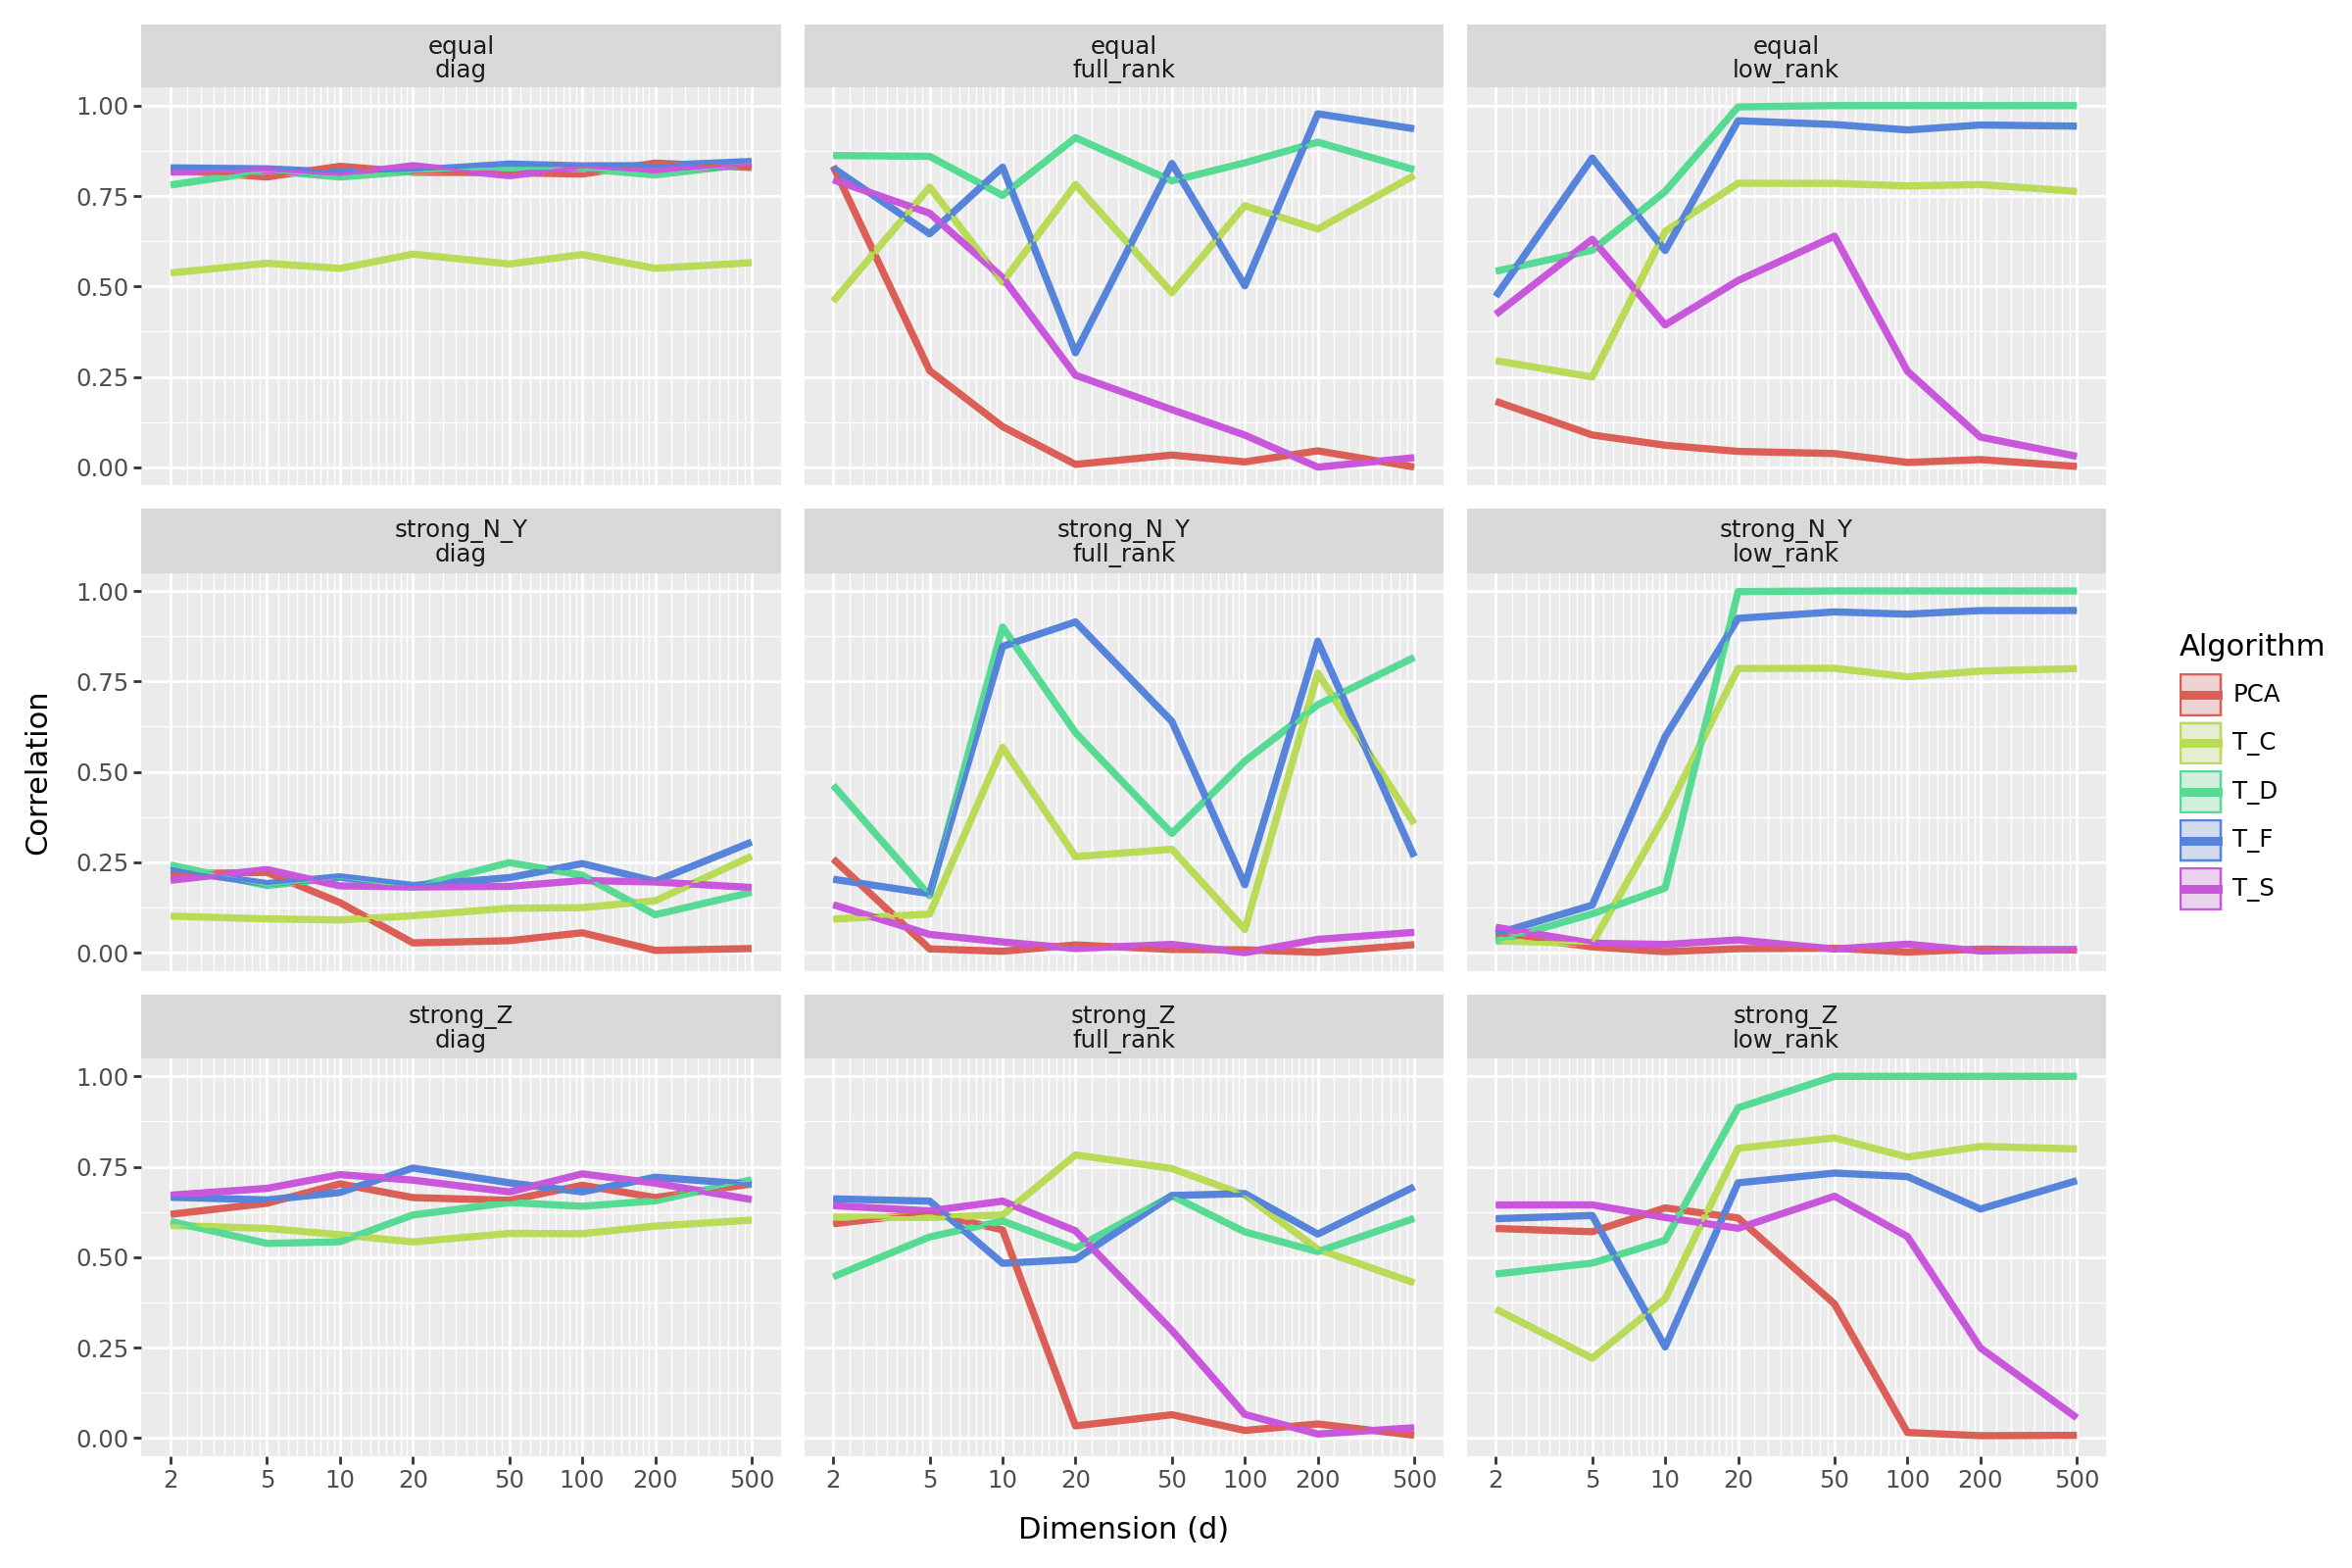

In [5]:
algo_names = {'PCA':'PCA', 'genCCA':'T_C', 'OptiDet':'T_D', 'Roy':'T_F', 'RoyS':'T_S'}
# Prepare data for ggplot
data = []
for weight_name in weights_names:
    for noise in noises:
        for algo in algorithms:
            algo_data = results[weight_name][noise][algo]
            values = np.array(algo_data)
            median = np.percentile(values, 50, axis=1)
            lower = np.percentile(values, 5, axis=1)
            upper = np.percentile(values, 95, axis=1)
            
            for i, dim in enumerate(dimensions):
                data.append({
                    'Dimension': dim,
                    'Median': median[i],
                    'Lower': lower[i],
                    'Upper': upper[i],
                    'Algorithm': algo_names[algo],
                    'Noise': noise,
                    'Weight': weight_name  # Add weight name to the data
                })

# Create a DataFrame
df = pd.DataFrame(data)

# Plot using ggplot with logarithmic scale on the x-axis
p = (ggplot(df, aes(x='Dimension', y='Median', color='Algorithm', fill='Algorithm'))
     + geom_line(size=1.5)
     + geom_ribbon(aes(ymin='Lower', ymax='Upper'), alpha=0.2)
     + scale_x_log10(breaks=dimensions)  # Set specific x-axis ticks to log scale
     + labs(x='Dimension (d)', y='Correlation')
     + facet_wrap('~Weight + Noise', ncol=3)  # Create facets for each weight and noise
     + theme(legend_position='right', figure_size=(12, 8))  # Set figure size
)

# Display the plot
print(p)
